<a href="https://colab.research.google.com/github/Nancy-Shi/Individual_Infection_Network/blob/main/1204_1000_SF_SW_clean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Compare scale-free and small-world networks**

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import pickle
import random
import numpy as np
import pandas as pd
import os
import sympy as sp
from sklearn.metrics import r2_score, mean_squared_error
from scipy.optimize import curve_fit
import math

In [ ]:
def generate_scale_free_network(N, k):
    if N < 2:
        return [[0]*N for _ in range(N)]

    m = max(1, k // 2)  # edges per new node
    m0 = max(m + 1, 2)  # initial fully connected core

    if m0 > N:
        m0 = N

    adj_matrix = [[0]*N for _ in range(N)]
    degree = [0]*N

    for i in range(m0):
        for j in range(i + 1, m0):
            adj_matrix[i][j] = 1
            adj_matrix[j][i] = 1
            degree[i] += 1
            degree[j] += 1

    targets = []
    for node, deg in enumerate(degree[:m0]):
        targets.extend([node] * deg)

    for new_node in range(m0, N):
        if not targets:
            possible = list(range(new_node))
            neighbors = random.sample(possible, min(m, len(possible)))
        else:
            neighbors = set()
            while len(neighbors) < m and len(neighbors) < new_node:
                candidate = random.choice(targets)
                if candidate != new_node and adj_matrix[new_node][candidate] == 0:
                    neighbors.add(candidate)
            neighbors = list(neighbors)

        for nb in neighbors:
            adj_matrix[new_node][nb] = 1
            adj_matrix[nb][new_node] = 1
            degree[new_node] += 1
            degree[nb] += 1
            targets.append(new_node)
            targets.append(nb)

    return adj_matrix

In [ ]:
def generate_small_world_network(N, k, p_rewire=0.1):
    if k % 2 != 0:
        raise ValueError("k must be even for a ring lattice.")
    if k >= N:
        raise ValueError("k must be less than N.")

    adj_matrix = [[0]*N for _ in range(N)]

    half_k = k // 2
    for i in range(N):
        for step in range(1, half_k + 1):
            j = (i + step) % N
            if i < j:
                adj_matrix[i][j] = 1
                adj_matrix[j][i] = 1

    for i in range(N):
        for step in range(1, half_k + 1):
            j = (i + step) % N
            if i < j and adj_matrix[i][j] == 1:
                if random.random() < p_rewire:
                    adj_matrix[i][j] = 0
                    adj_matrix[j][i] = 0

                    while True:
                        new_j = random.randrange(N)
                        if new_j != i and adj_matrix[i][new_j] == 0:
                            break

                    adj_matrix[i][new_j] = 1
                    adj_matrix[new_j][i] = 1

    return adj_matrix

In [ ]:
# Function to generate a network from an N by N adjacency matrix.
def generate_network(adj_matrix):
    G = nx.Graph()
    N = len(adj_matrix)
    G.add_nodes_from(range(N))
    for i in range(N):
        for j in range(i+1, N):
            if adj_matrix[i][j] == 1:
                G.add_edge(i, j)
    return G

In [ ]:
def preprocess_neighbors(G):
    nodes = list(G.nodes())
    node_index = {v: i for i, v in enumerate(nodes)}
    neighbors_idx = []

    for v in nodes:
        neighs = list(G.neighbors(v))
        neighbors_idx.append(np.array([node_index[u] for u in neighs], dtype=int))

    return nodes, node_index, neighbors_idx

In [ ]:
def fixed_point_solver_message_passing(neighbors_idx, seed_index, p_val, tol=1e-6, max_iter=5000, relax=0.3):

    n = len(neighbors_idx)

    edge_to_idx = {}
    idx_to_edge = []

    for i in range(n):
        for j in neighbors_idx[i]:
            edge_to_idx[(j, i)] = len(idx_to_edge)
            idx_to_edge.append((j, i))

    m = len(idx_to_edge)

    # Messages theta_{j->i}: probability that j does NOT infect i
    theta = np.ones(m, dtype=float)

    for _ in range(max_iter):
        theta_new = theta.copy()

        for e_idx, (j, i) in enumerate(idx_to_edge):
            if j == seed_index:
                theta_new[e_idx] = 1.0 - p_val
                continue

            neigh_j = neighbors_idx[j]

            # Compute u_{j->i} = product over k in N(j)\{i} of theta_{k->j}
            if len(neigh_j) == 0:
                u = 1.0
            else:
                prod = 1.0
                for k in neigh_j:
                    if k == i:
                        continue
                    prod *= theta[edge_to_idx[(k, j)]]
                u = prod

            theta_new[e_idx] = 1.0 - p_val + p_val * u

        theta_updated = (1.0 - relax) * theta + relax * theta_new

        if np.max(np.abs(theta_updated - theta)) < tol:
            theta = theta_updated
            break

        theta = theta_updated

    sigma = np.zeros(n, dtype=float)

    for i in range(n):
        if i == seed_index:
            sigma[i] = 1.0
            continue

        neigh_i = neighbors_idx[i]
        if len(neigh_i) == 0:
            sigma[i] = 0.0
            continue

        prod = 1.0
        for j in neigh_i:
            prod *= theta[edge_to_idx[(j, i)]]
        sigma[i] = 1.0 - prod

    return sigma

In [ ]:
from joblib import Parallel, delayed

def compute_attack_matrix(G, p_val, n_jobs=-1):
    nodes, node_index, neighbors_idx = preprocess_neighbors(G)
    n = len(nodes)

    sigmas = Parallel(n_jobs=n_jobs)(
        delayed(fixed_point_solver_message_passing)(neighbors_idx, seed_index=node_index[s], p_val=p_val)
        for s in nodes
    )

    mat = np.array(sigmas).T

    return nodes, mat



def save_attack_csv(nodes, mat, p_val, label, outdir="/content/drive/My Drive/Individual_Attack_Rate"):
    os.makedirs(outdir, exist_ok=True)
    df = pd.DataFrame(
        mat,
        index=[f"sigma_{i}" for i in nodes],
        columns=[f"Seed {i}" for i in nodes]
    )
    path = os.path.join(outdir, f"individual_attack_{label}.csv")
    df.to_csv(path, float_format="%.6f")
    return path, df

In [ ]:
# Function to compute the average infection rate by taking the average of the matrix for each row, excluding the 1 value (seed node case)
def compute_average_attack(nodes, mat):
    mat_no_diag = mat.copy()
    np.fill_diagonal(mat_no_diag, np.nan)   # remove self-seed values
    return np.nanmean(mat_no_diag, axis=1)

def save_average_attack_csv(nodes, avg_attack, p_val, outdir="/content/drive/My Drive/Individual_Attack_Rate"):
    os.makedirs(outdir, exist_ok=True)

    df = pd.DataFrame({
        "Node": nodes,
        "AverageAttackRate": avg_attack
    })

    path = os.path.join(outdir, f"average_SF_SW.csv")
    df.to_csv(path, index=False, float_format="%.6f")

    return path, df


In [ ]:
# Function to visualize the network based on the node index, color the nodes based on a heatmap scale using their average attack rate
def visualize_attack_network_comparison(
    G_SF, nodes_SF, avg_SF,
    G_SM, nodes_SM, avg_SM,
    cmap_name="jet",
    out_path=None
):
    avg_SF = np.asarray(avg_SF, dtype=float)
    avg_SM = np.asarray(avg_SM, dtype=float)

    all_vals = np.concatenate([avg_SF, avg_SM])
    vmin = float(np.nanmin(all_vals))
    vmax = float(np.nanmax(all_vals))

    fig, axes = plt.subplots(1, 2, figsize=(22, 12))

    def draw_panel(ax, G, nodes, avg_attack, panel_label, vmin, vmax):
        nodes = list(nodes)
        avg_attack = np.asarray(avg_attack, dtype=float)
        attack_dict = {node: avg_attack[i] for i, node in enumerate(nodes)}

        pos = nx.spring_layout(G, seed=42, k=0.25, iterations=300)
        node_colors = [attack_dict[n] for n in G.nodes()]

        nx.draw_networkx_edges(G, pos, ax=ax, alpha=0.8, width=1.0, edge_color="gray")
        nodes_draw = nx.draw_networkx_nodes(
            G, pos, ax=ax,
            node_color=node_colors,
            cmap=plt.get_cmap(cmap_name),
            node_size=40,
            linewidths=0.4,
            edgecolors="black",
            vmin=vmin, vmax=vmax
        )

        ax.set_axis_off()
        ax.text(
            0.03, 0.97, panel_label,
            transform=ax.transAxes,
            ha="left", va="top",
            fontsize=22, fontweight="bold"
        )
        return nodes_draw

    # Panel A — scale-free
    nodes_draw = draw_panel(
        axes[0], G_SF, nodes_SF, avg_SF,
        panel_label="A (Scale-Free)", vmin=vmin, vmax=vmax
    )

    # Panel B — small-world
    draw_panel(
        axes[1], G_SM, nodes_SM, avg_SM,
        panel_label="B (Small-World)", vmin=vmin, vmax=vmax
    )

    fig.tight_layout(rect=[0.03, 0.10, 0.97, 1.0])

    cbar_ax = fig.add_axes([0.20, 0.04, 0.60, 0.02])
    cbar = fig.colorbar(nodes_draw, cax=cbar_ax, orientation="horizontal")
    cbar.set_label("Average individual infection probability", fontsize=12)
    cbar.ax.tick_params(labelsize=10)

    if out_path is not None:
        plt.savefig(out_path, dpi=1200, bbox_inches="tight")
    plt.show()

In [ ]:
def save_graph_neighbor_csv(G, filename, outdir="/content/drive/My Drive/Individual_Attack_Rate"):
    os.makedirs(outdir, exist_ok=True)
    path = os.path.join(outdir, filename)

    nodes = sorted(G.nodes())
    index_map = {v: i for i, v in enumerate(nodes)}

    data = []
    for v in nodes:
        neigh_indices = [index_map[u] for u in G.neighbors(v)]
        neigh_str = ",".join(str(n) for n in neigh_indices)
        degree = len(neigh_indices)
        data.append([index_map[v], neigh_str, degree])

    df = pd.DataFrame(data, columns=["node", "neighbors", "degree"])
    df.to_csv(path, index=False)

    return path, df

In [ ]:
import pandas as pd
import os

def rank_nodes_by_attack(csv_path, outdir="/content/drive/My Drive/Individual_Attack_Rate"):
    df = pd.read_csv(csv_path)

    df_ranked = df.sort_values(by="AverageAttackRate", ascending=False).reset_index(drop=True)

    df_ranked["Rank"] = df_ranked.index + 1

    os.makedirs(outdir, exist_ok=True)
    out_path = os.path.join(outdir, "ranked_SF_SW_" + os.path.basename(csv_path))
    df_ranked.to_csv(out_path, index=False, float_format="%.6f")

    print("\nRanked results:\n")
    print(df_ranked.head())

    return out_path, df_ranked

In [ ]:
def plot_ranked_histogram_two_panel(
    ranked_csv_path_SF,
    ranked_csv_path_SW,
    outdir,
    fig_name
):
    import pandas as pd
    import matplotlib.pyplot as plt
    import numpy as np
    import os

    def build_hist(ax, ranked_csv, panel_label):
        df = pd.read_csv(ranked_csv)
        vals = df["AverageAttackRate"].values
        vals = vals[~np.isnan(vals)]

        plt.style.use("seaborn-v0_8-white")

        main_bins = np.arange(0, 1.1, 0.1)
        hist_bins = np.arange(0, 1.05 + 0.001, 0.05)
        colors = plt.cm.rainbow(np.linspace(0, 1, len(main_bins)-1))

        for i in range(len(main_bins)-1):
            lo, hi = main_bins[i], main_bins[i+1]
            mask = (vals >= lo) & (vals < hi)

            ax.hist(
                vals[mask],
                bins=hist_bins,
                alpha=0.85,
                color=colors[i],
                edgecolor="white",
                linewidth=0.4
            )

        ax.set_xlabel("Individual Infection Probability", fontsize=10)
        ax.set_ylabel("Density", fontsize=10)

        ax.text(
            0.03, 0.97, panel_label,
            transform=ax.transAxes,
            ha="left", va="top",
            fontsize=14, fontweight="bold"
        )

        ax.tick_params(labelsize=8)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["left"].set_linewidth(1.2)
        ax.spines["bottom"].set_linewidth(1.2)
        ax.set_xlim(-0.1, 1.0)

    fig, axes = plt.subplots(1, 2, figsize=(12, 4), dpi=300)

    build_hist(axes[0], ranked_csv_path_SF, panel_label="A")
    build_hist(axes[1], ranked_csv_path_SW, panel_label="B")

    plt.tight_layout()

    fig_path = os.path.join(outdir, fig_name)
    plt.savefig(fig_path, bbox_inches="tight", dpi=300)
    plt.show()


In [ ]:
def logistic(x, L, k, x0):
    return L / (1 + np.exp(-k * (x - x0)))

def plot_saturating(ax, x_raw, y, xlabel, panel_label, color):
    x_scaled = x_raw.values * 1e3
    x = x_scaled
    p0 = [1.0, 1.0, np.median(x)]
    params, _ = curve_fit(logistic, x, y, p0=p0, maxfev=20000)
    L, k, x0 = params
    y_pred = logistic(x, L, k, x0)

    r2 = r2_score(y, y_pred)
    rmse = np.sqrt(mean_squared_error(y, y_pred))

    order = np.argsort(x)
    xs = x[order]
    ys = y[order]
    yfit = y_pred[order]

    ax.scatter(xs, ys, s=12, alpha=0.7, color=color, edgecolor="none")
    ax.plot(xs, yfit, lw=2.2, color=color)

    ax.set_xlabel(f"{xlabel} ($\\times 10^{{-3}}$)")
    ax.set_ylabel("Infection probability")

    ax.text(
        0.03, 0.97, panel_label,
        transform=ax.transAxes,
        ha="left", va="top",
        fontsize=14, fontweight="bold"
    )

    ax.text(
        0.97, 0.03,
        f"$R^2 = {r2:.3f}$\nRMSE = {rmse:.3f}",
        transform=ax.transAxes, ha="right", va="bottom",
        fontsize=10,
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="0.6", alpha=0.9)
    )

    formula = r"$y = \frac{{{:.3f}}}{{1 + \exp[-{:.3f}(x - {:.3f})]}}$".format(L, k, x0)
    ax.text(
        0.25, 0.20, formula,
        transform=ax.transAxes,
        fontsize=10, ha="left", va="bottom",
        bbox=dict(boxstyle="round,pad=0.25", fc="white", ec="0.6", alpha=0.85)
    )

    ax.tick_params(direction="in", top=True, right=True)
    ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.35)
    ax.set_xlim(left=0)
    ax.set_ylim(0, 1.0)

    return (L, k, x0, r2, rmse)

In [ ]:
def make_centrality_figure(
    neighbors_path_SF,
    ranked_path_SF,
    neighbors_path_SW,
    ranked_path_SW,
    outdir,
    merged_basename_SF,
    merged_basename_SW,
    fig_basename
):
    # Scale-free
    df_neighbors_SF = pd.read_csv(neighbors_path_SF)
    df_ranked_SF = pd.read_csv(ranked_path_SF)

    G_SF = nx.Graph()
    for _, row in df_neighbors_SF.iterrows():
        i = int(row["node"])
        neighs = [int(x) for x in str(row["neighbors"]).split(",") if str(x).strip() != ""]
        for j in neighs:
            G_SF.add_edge(i, j)

    deg_cent_SF = nx.degree_centrality(G_SF)
    bet_cent_SF = nx.betweenness_centrality(G_SF, normalized=True)

    centrality_SF = pd.DataFrame({
        "node": list(deg_cent_SF.keys()),
        "degree_centrality": [deg_cent_SF[n] for n in deg_cent_SF],
        "betweenness_centrality": [bet_cent_SF[n] for n in deg_cent_SF],
    })

    df_ranked_SF = df_ranked_SF.copy()
    df_ranked_SF["node"] = df_ranked_SF["Node"]

    merged_SF = df_ranked_SF.merge(centrality_SF, on="node", how="left").drop(columns=["node"])
    merged_path_SF = os.path.join(outdir, merged_basename_SF)
    merged_SF.to_csv(merged_path_SF, index=False)

    # Small-world
    df_neighbors_SW = pd.read_csv(neighbors_path_SW)
    df_ranked_SW = pd.read_csv(ranked_path_SW)

    G_SW = nx.Graph()
    for _, row in df_neighbors_SW.iterrows():
        i = int(row["node"])
        neighs = [int(x) for x in str(row["neighbors"]).split(",") if str(x).strip() != ""]
        for j in neighs:
            G_SW.add_edge(i, j)

    deg_cent_SW = nx.degree_centrality(G_SW)
    bet_cent_SW = nx.betweenness_centrality(G_SW, normalized=True)

    centrality_SW = pd.DataFrame({
        "node": list(deg_cent_SW.keys()),
        "degree_centrality": [deg_cent_SW[n] for n in deg_cent_SW],
        "betweenness_centrality": [bet_cent_SW[n] for n in deg_cent_SW],
    })

    df_ranked_SW = df_ranked_SW.copy()
    df_ranked_SW["node"] = df_ranked_SW["Node"]

    merged_SW = df_ranked_SW.merge(centrality_SW, on="node", how="left").drop(columns=["node"])
    merged_path_SW = os.path.join(outdir, merged_basename_SW)
    merged_SW.to_csv(merged_path_SW, index=False)

    # Plot
    y_SF = merged_SF["AverageAttackRate"].values
    y_SW = merged_SW["AverageAttackRate"].values

    fig, axes = plt.subplots(2, 2, figsize=(10, 8))

    # Scale-free
    plot_saturating(
        axes[0, 0], merged_SF["degree_centrality"], y_SF,
        xlabel="Degree centrality (scale-free)", panel_label="A", color="#1f77b4"
    )
    plot_saturating(
        axes[0, 1], merged_SF["betweenness_centrality"], y_SF,
        xlabel="Betweenness centrality (scale-free)", panel_label="B", color="#6a3d9a"
    )

    # Small-world
    plot_saturating(
        axes[1, 0], merged_SW["degree_centrality"], y_SW,
        xlabel="Degree centrality (small-world)", panel_label="C", color="#1f77b4"
    )
    plot_saturating(
        axes[1, 1], merged_SW["betweenness_centrality"], y_SW,
        xlabel="Betweenness centrality (small-world)", panel_label="D", color="#6a3d9a"
    )

    for ax in axes.flat:
        ax.set_xlim(left=0)
        ax.set_ylim(0, 1.0)
        ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.35)

    fig.tight_layout()
    fig_path = os.path.join(outdir, fig_basename)
    plt.savefig(fig_path, dpi=600, bbox_inches="tight")
    plt.show()

    return merged_path_SF, merged_path_SW

In [ ]:
N = 1000
k = 10
p_val = 0.1
p_rewire = 0.1

# Generate adjacency matrices for scale-free and small-world networks
adj_SF = generate_scale_free_network(N, k)
adj_SW = generate_small_world_network(N, k, p_rewire=p_rewire)

outdir = "/content/drive/My Drive/Individual_Attack_Rate"

cases = [("SF", adj_SF), ("SW", adj_SW)]

G_SF = None
nodes_SF = None
avg_attack_SF = None
neighbors_SF_path = None
ranked_SF_path = None

G_SW = None
nodes_SW = None
avg_attack_SW = None
neighbors_SW_path = None
ranked_SW_path = None

for label, adj_matrix in cases:
    G = generate_network(adj_matrix)

    with open(f"{outdir}/graph_{label}.pkl", "wb") as f:
        pickle.dump(G, f)

    np.savetxt(
        f"{outdir}/adj_matrix_{label}.csv",
        np.array(adj_matrix, dtype=int),
        fmt="%d",
        delimiter=","
    )

    neigh_filename = f"graph_neighbors_{label}.csv"
    neigh_path, df_neigh = save_graph_neighbor_csv(G, neigh_filename, outdir=outdir)

    nodes, attack_mat = compute_attack_matrix(G, p_val)

    indiv_path, df_indiv = save_attack_csv(
        nodes, attack_mat, p_val, label, outdir=outdir
    )

    avg_attack = compute_average_attack(nodes, attack_mat)

    avg_path, df_avg = save_average_attack_csv(
        nodes, avg_attack, p_val, outdir=outdir
    )
    labeled_avg_path = os.path.join(
        outdir, f"average_attack_{label}.csv"
    )
    os.rename(avg_path, labeled_avg_path)

    ranked_path, df_ranked = rank_nodes_by_attack(
        labeled_avg_path,
        outdir=outdir
    )
    labeled_ranked_path = os.path.join(
        outdir, f"ranked_attack_{label}.csv"
    )
    os.rename(ranked_path, labeled_ranked_path)

    if label == "SF":
        G_SF = G
        nodes_SF = nodes
        avg_attack_SF = avg_attack
        neighbors_SF_path = neigh_path
        ranked_SF_path = labeled_ranked_path
    elif label == "SW":
        G_SW = G
        nodes_SW = nodes
        avg_attack_SW = avg_attack
        neighbors_SW_path = neigh_path
        ranked_SW_path = labeled_ranked_path




Ranked results:

   Node  AverageAttackRate  Rank
0     3           0.996136     1
1     0           0.994505     2
2     4           0.990873     3
3    11           0.982717     4
4     5           0.971334     5

Ranked results:

   Node  AverageAttackRate  Rank
0   969           0.010429     1
1   179           0.010199     2
2   309           0.010191     3
3   744           0.010179     4
4   746           0.010175     5


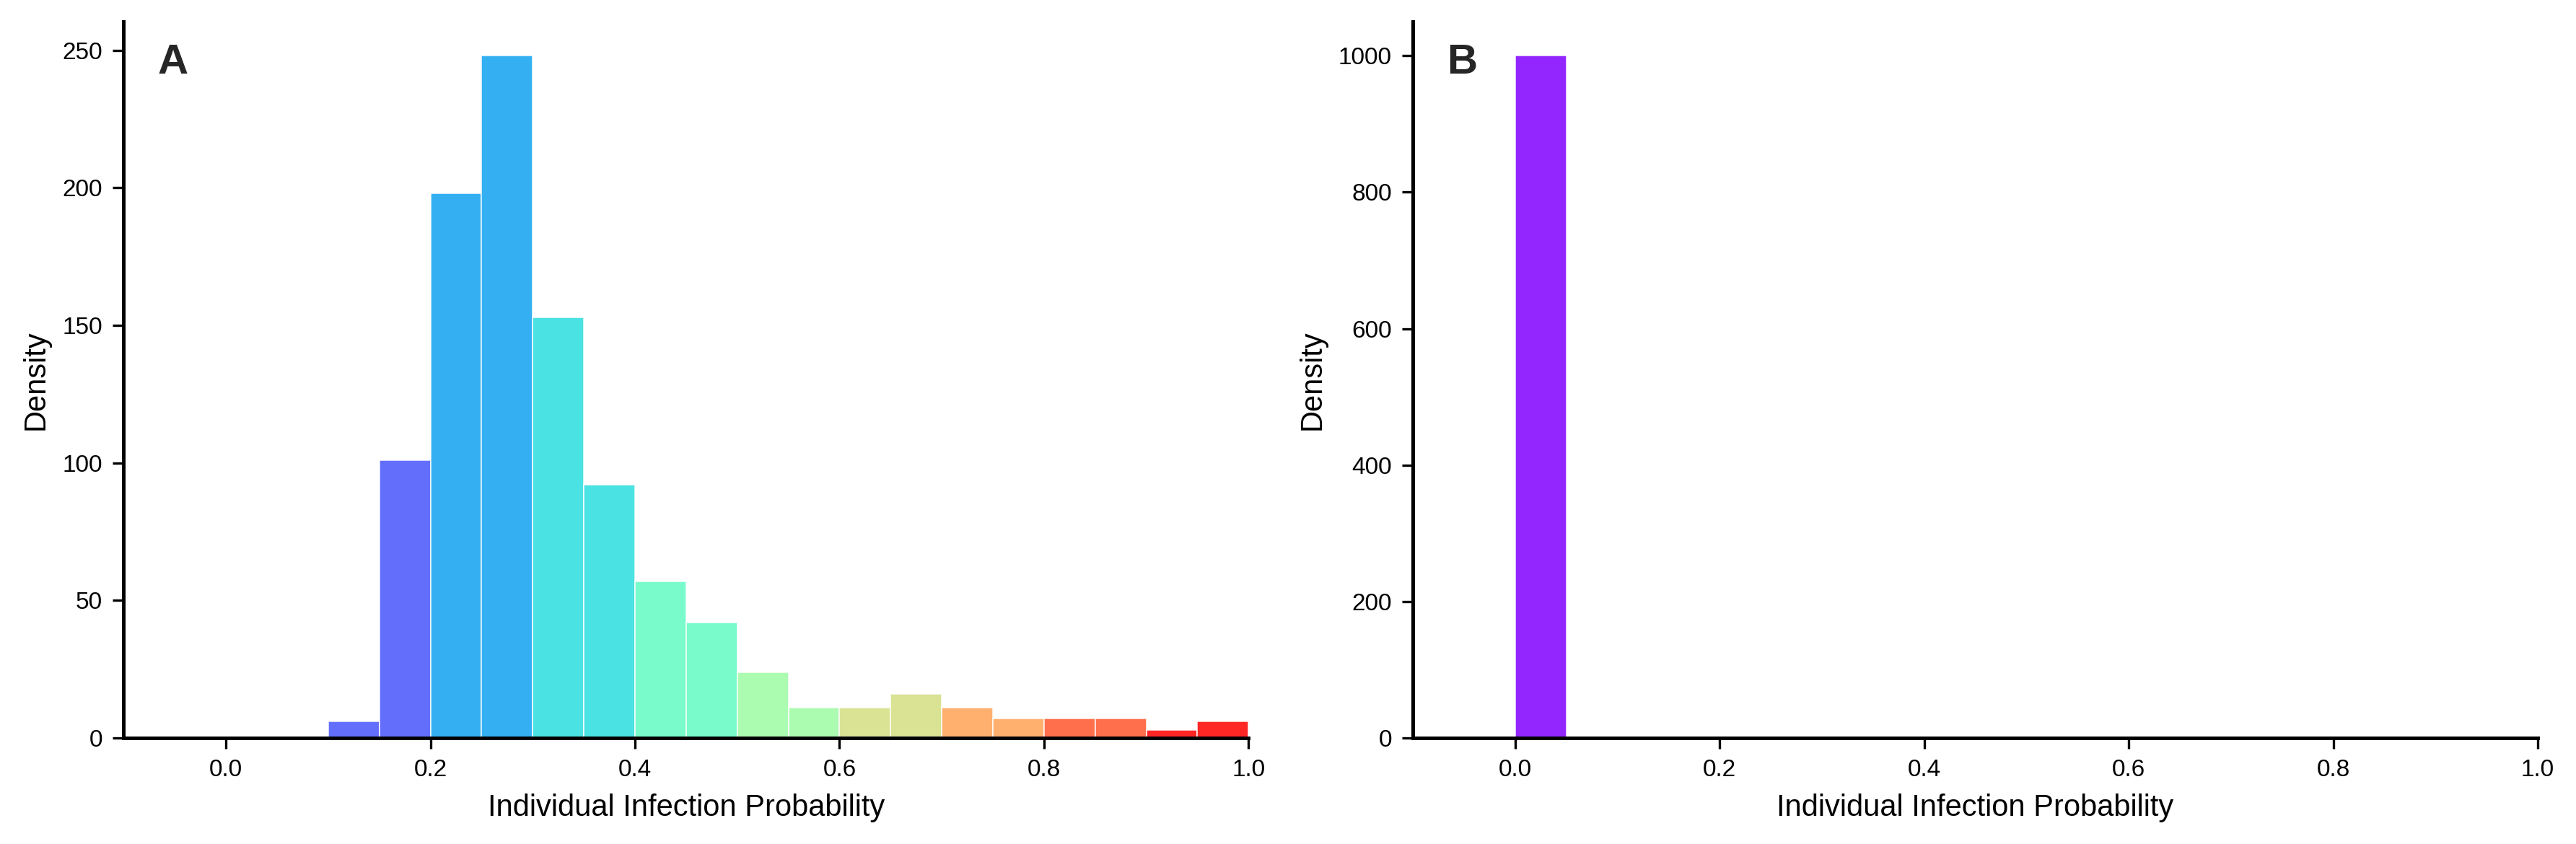

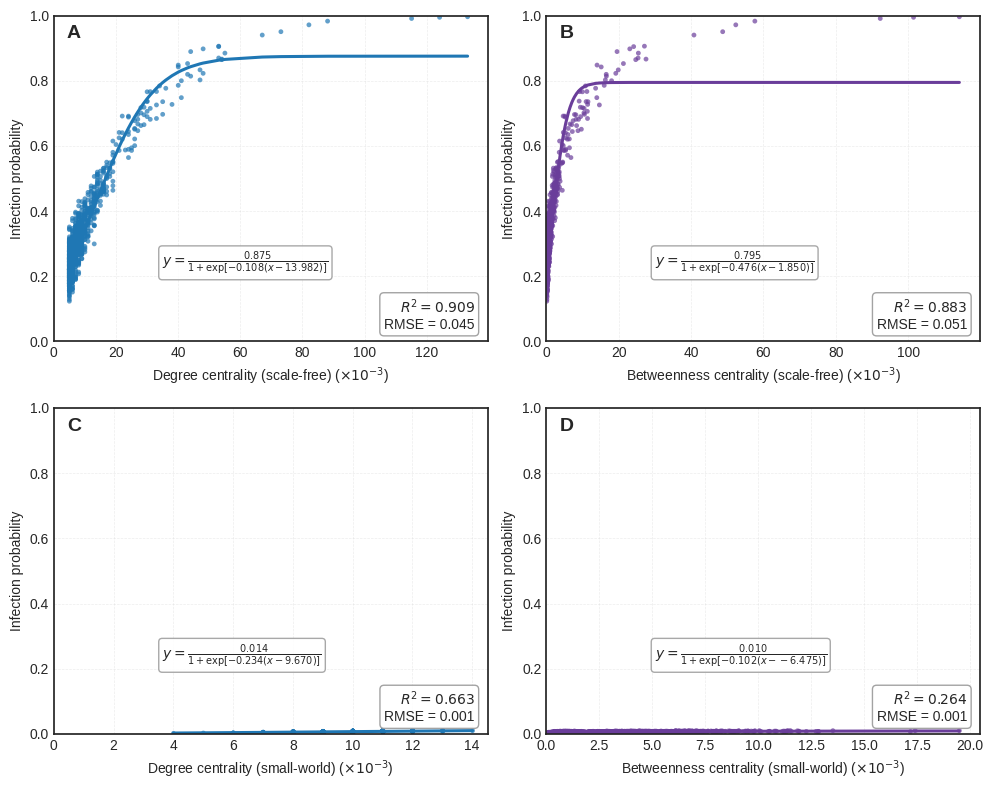

('/content/drive/My Drive/Individual_Attack_Rate/ranked_with_centrality_SF.csv',
 '/content/drive/My Drive/Individual_Attack_Rate/ranked_with_centrality_SW.csv')

In [ ]:
# pairwise comparisons (after loop)

plot_ranked_histogram_two_panel(
    ranked_csv_path_SF=ranked_SF_path,
    ranked_csv_path_SW=ranked_SW_path,
    outdir=outdir,
    fig_name=f"hist_ranked_attack_compare_SF_SW.pdf"
)

make_centrality_figure(
    neighbors_path_SF=neighbors_SF_path,
    ranked_path_SF=ranked_SF_path,
    neighbors_path_SW=neighbors_SW_path,
    ranked_path_SW=ranked_SW_path,
    outdir=outdir,
    merged_basename_SF=f"ranked_with_centrality_SF.csv",
    merged_basename_SW=f"ranked_with_centrality_SW.csv",
    fig_basename=f"centrality_SF_vs_SW.pdf"
)

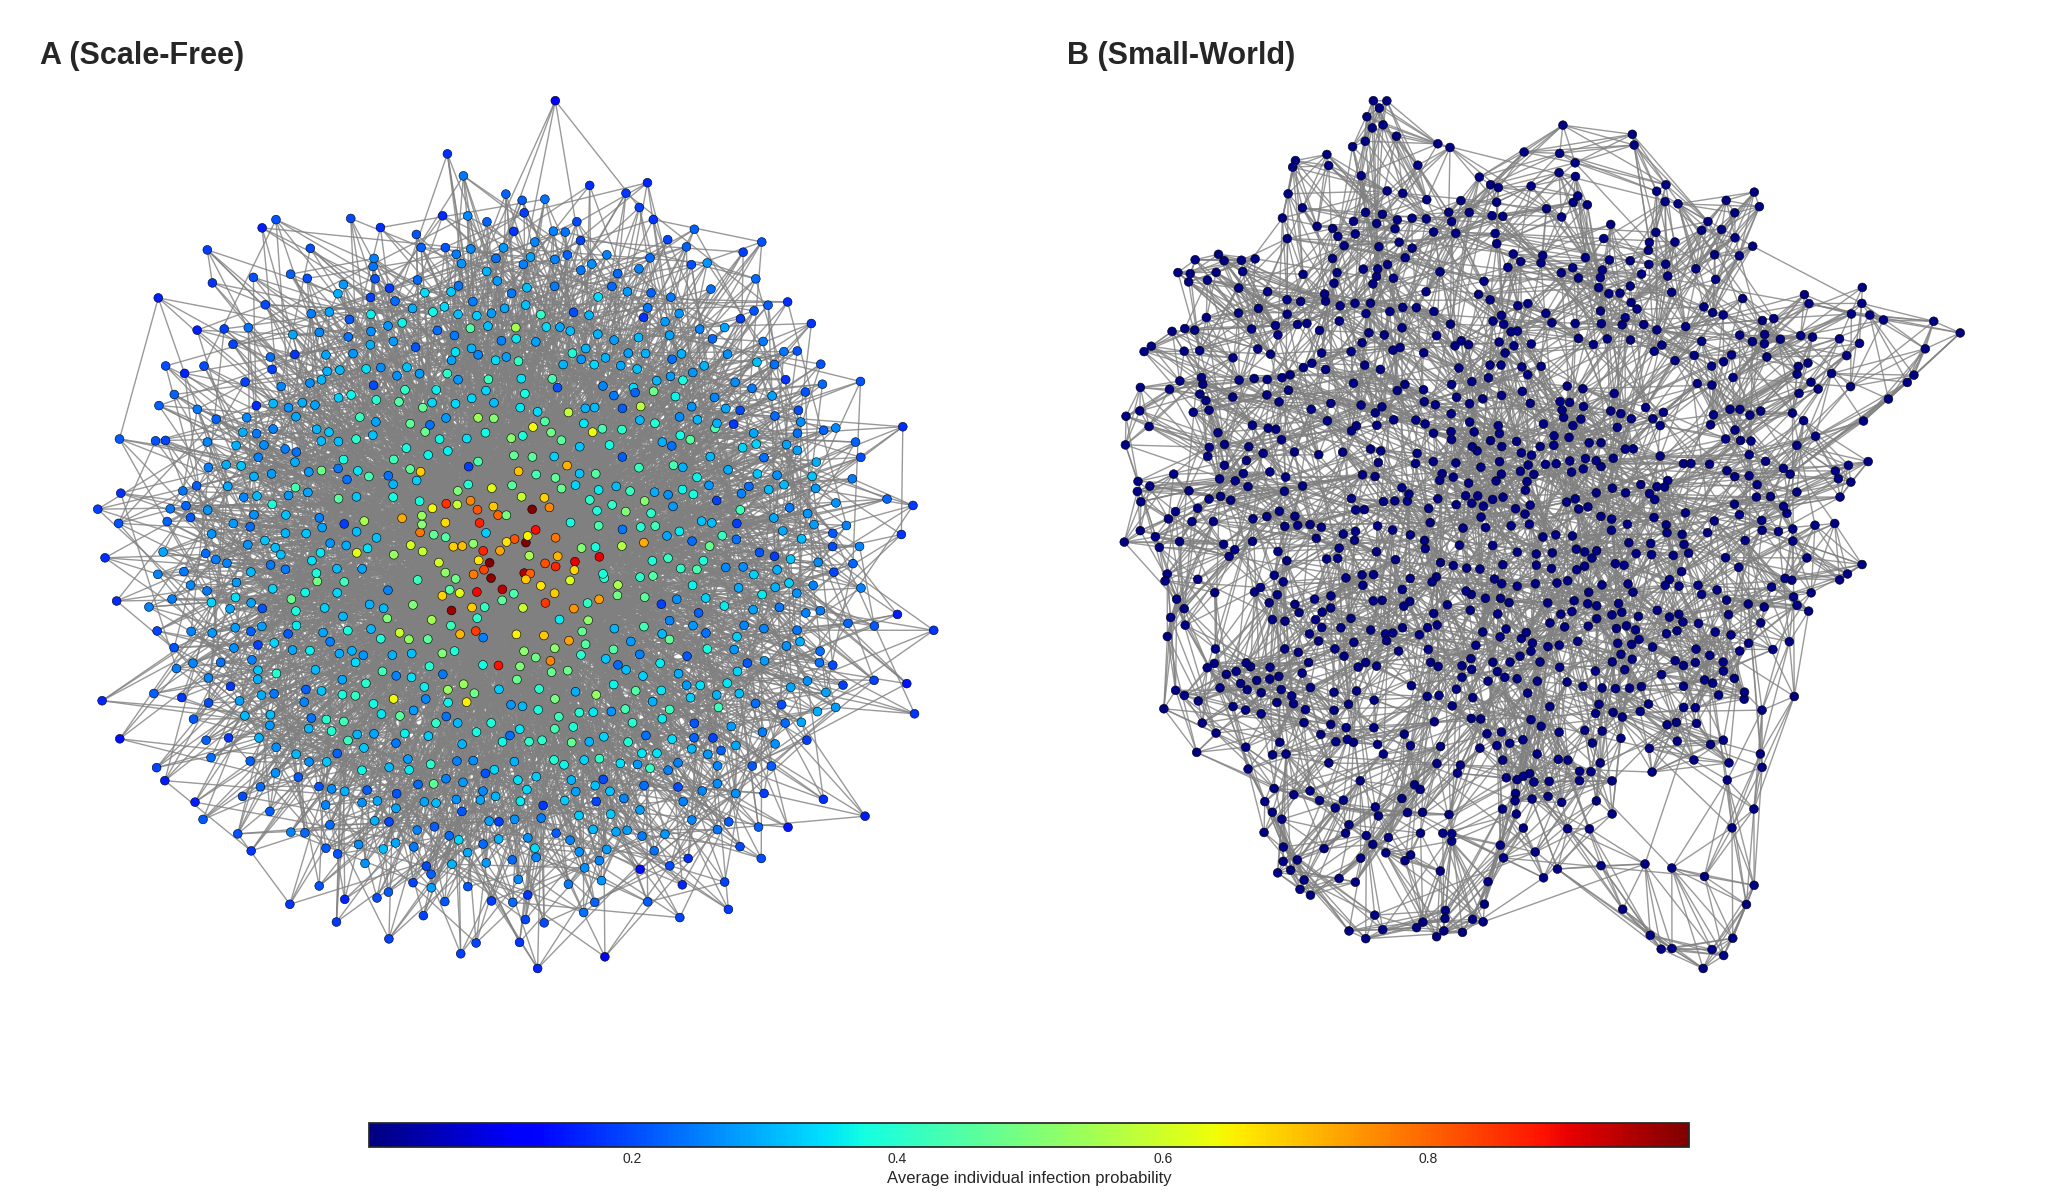

In [ ]:
visualize_attack_network_comparison(
    G_SF, nodes_SF, avg_attack_SF,
    G_SW, nodes_SW, avg_attack_SW,
    cmap_name="jet",
    out_path=os.path.join(outdir, f"network_compare_SF_SW.pdf")
)

In [ ]:
# Histogram for distribution of probability for a node of a certain degree
def plot_prob_histograms_by_degree(individual_csv,
                                   neighbors_csv,
                                   bins=np.linspace(0, 1, 21),
                                   max_cols=6,
                                   save_pdf=True,
                                   outname="histograms_by_degree.pdf"):

    df_indiv = pd.read_csv(individual_csv)
    df_deg   = pd.read_csv(neighbors_csv)

    prob_cols = [c for c in df_indiv.columns if c.startswith("Seed ")]
    probs = df_indiv[prob_cols].to_numpy()

    np.fill_diagonal(probs, np.nan)

    N = probs.shape[0]
    deg_series = df_deg.set_index("node")["degree"].reindex(np.arange(N))

    unique_degrees = np.sort(deg_series.unique())
    n_deg = len(unique_degrees)

    n_cols = min(max_cols, n_deg)
    n_rows = math.ceil(n_deg / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols,
                             figsize=(4 * n_cols, 3.2 * n_rows),
                             sharex=True, sharey=True)

    if n_deg == 1:
        axes = np.array([axes])
    axes = axes.flatten()

    for idx, k in enumerate(unique_degrees):
        ax = axes[idx]
        nodes_k = np.where(deg_series.values == k)[0]
        data_k = probs[nodes_k, :].ravel() # get all the probabilities for these rows
        data_k = data_k[~np.isnan(data_k)]

        if len(data_k) > 0:
            weights = np.ones_like(data_k) * 100.0 / len(data_k)
            ax.hist(data_k, bins=bins, weights=weights, edgecolor="black")

        ax.set_title(f"Degree k={k} (n={len(nodes_k)})")

        row = idx // n_cols
        col = idx % n_cols

        if row == n_rows - 1:
            ax.set_xlabel("Probability")
        else:
            ax.set_xlabel("")

        if col == 0:
            ax.set_ylabel("Frequency (%)")
        else:
            ax.set_ylabel("")

    for j in range(n_deg, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()

    if save_pdf:
        outdir = os.path.dirname(individual_csv)
        outfile = os.path.join(outdir, outname)
        plt.savefig(outfile, format="pdf", dpi=300, bbox_inches="tight")
        print("Saved PDF to:", outfile)

    plt.show()

Saved PDF to: /content/drive/My Drive/Individual_Attack_Rate/degree_hist_panels_SF.pdf


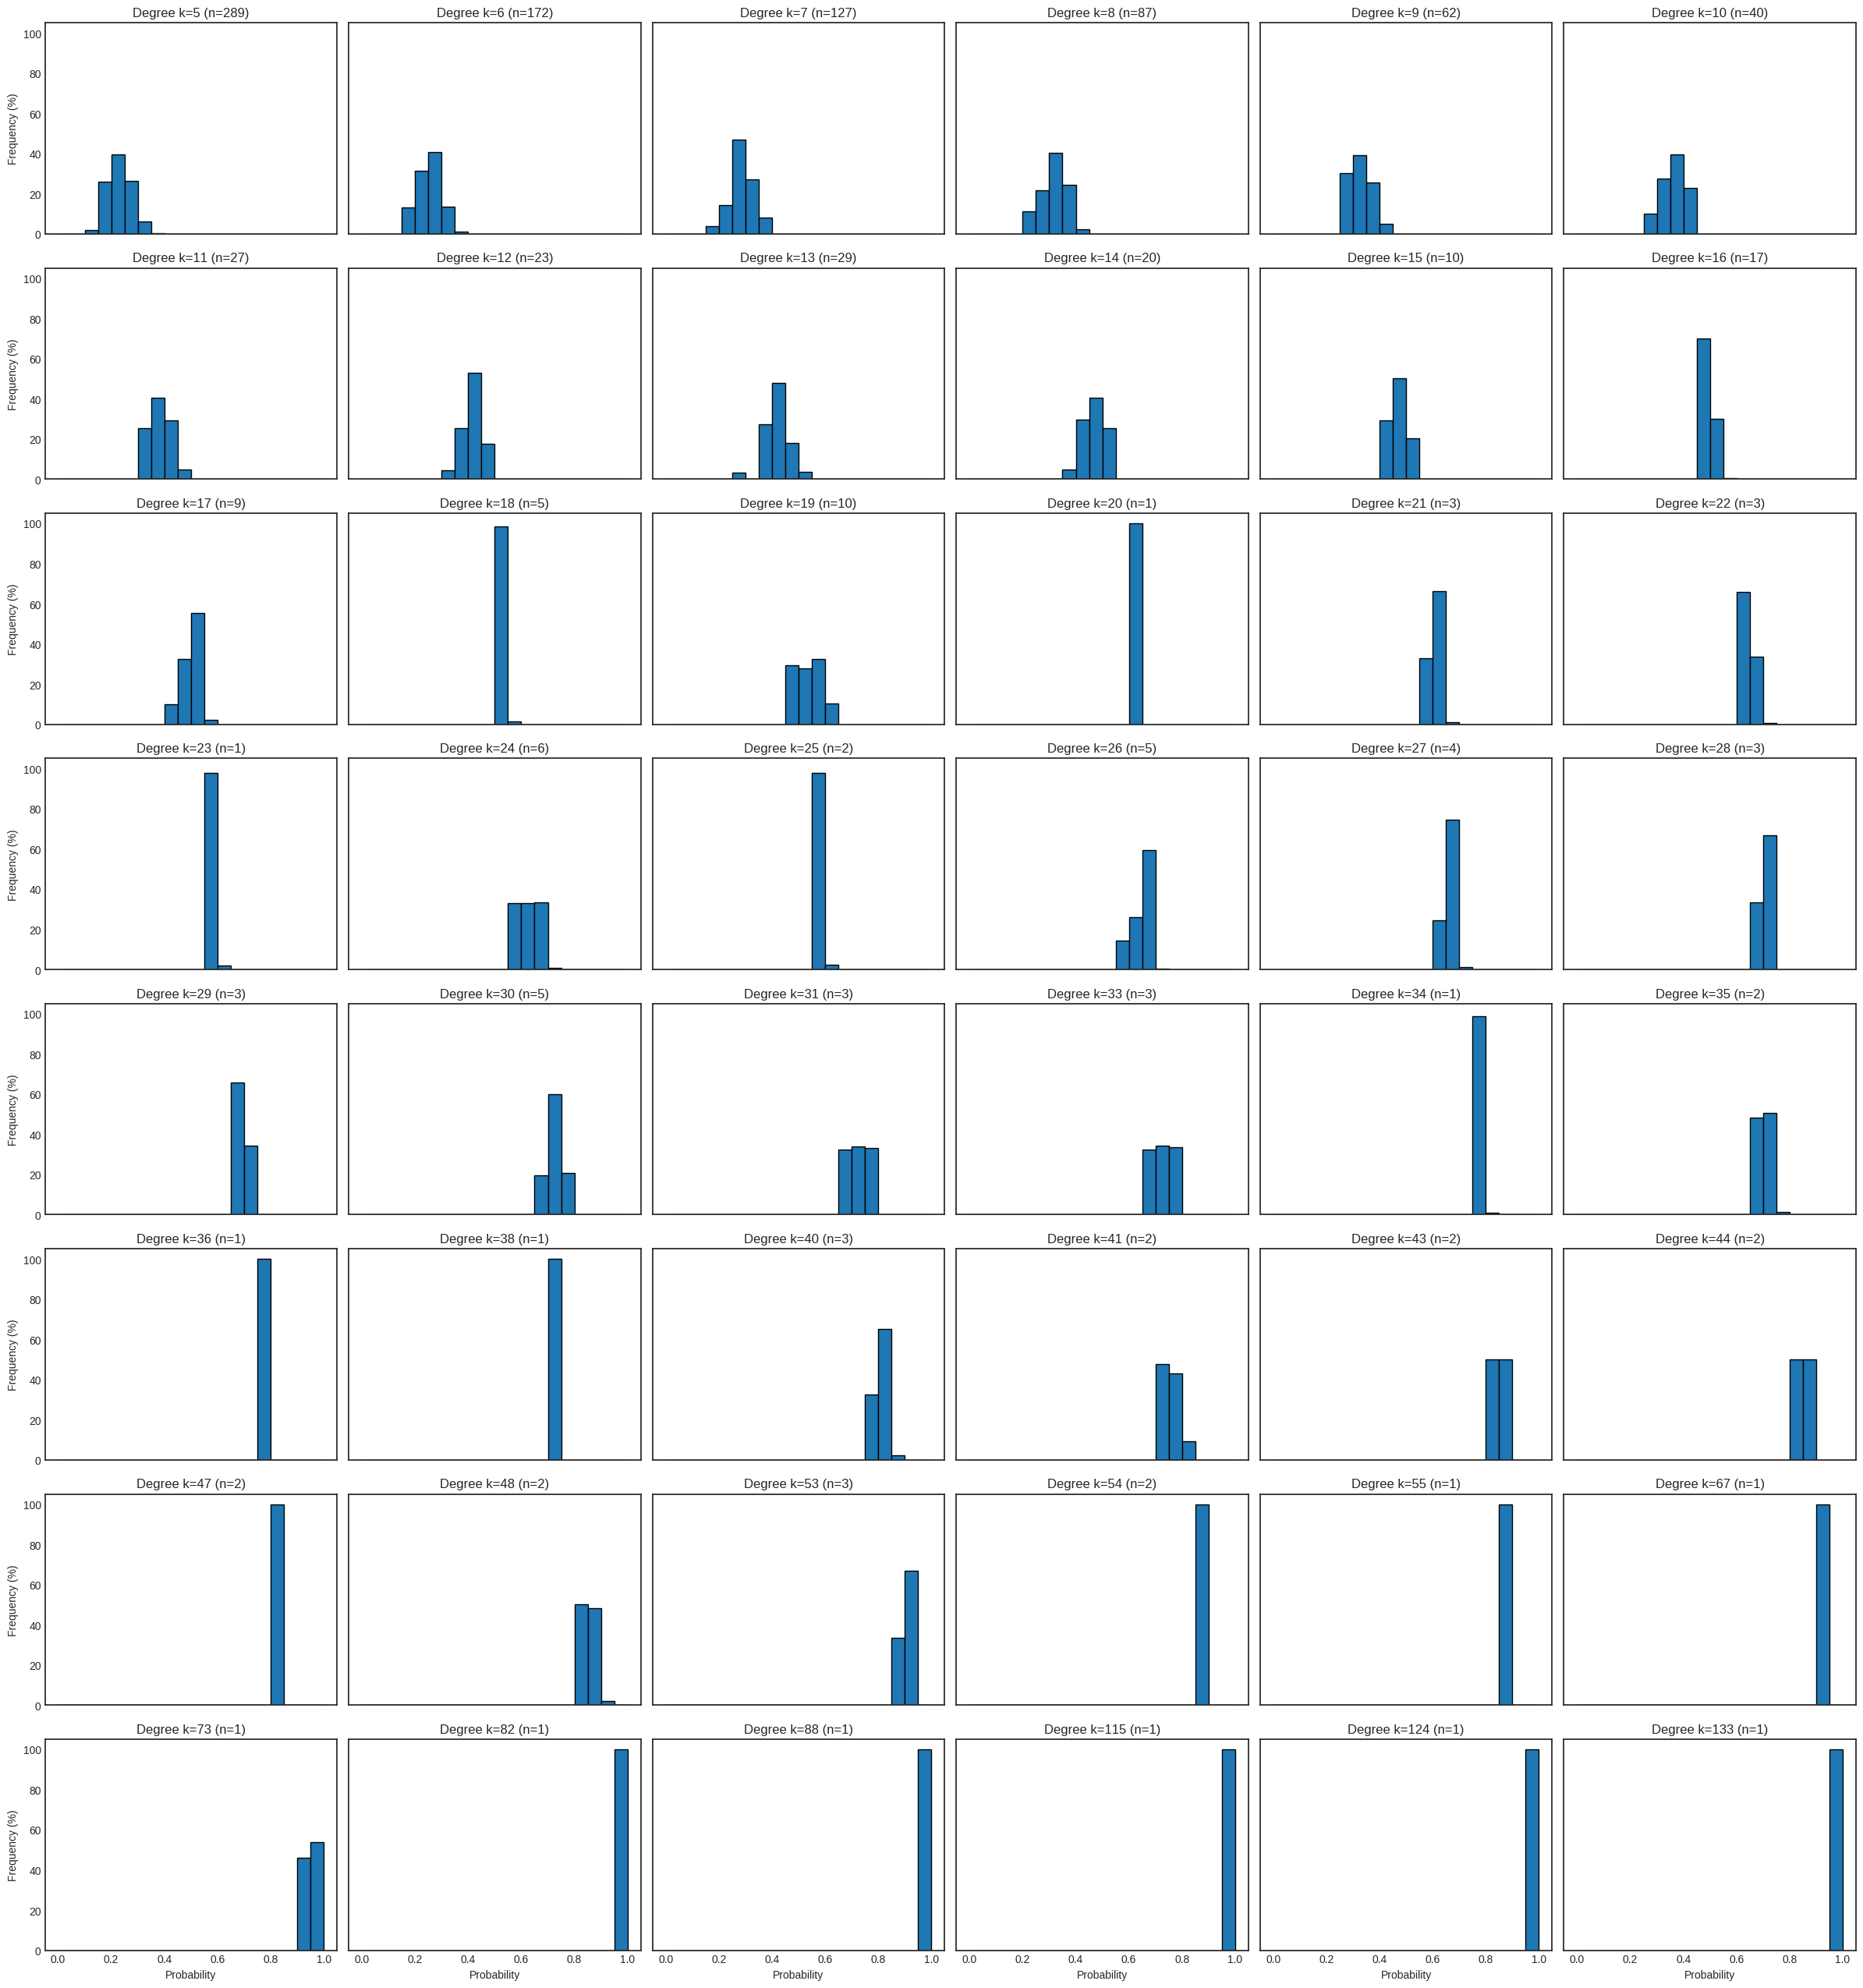

In [ ]:
individual_csv_SF = "/content/drive/My Drive/Individual_Attack_Rate/individual_attack_SF.csv"
neighbors_csv_SF  = "/content/drive/My Drive/Individual_Attack_Rate/graph_neighbors_SF.csv"

plot_prob_histograms_by_degree(
    individual_csv_SF,
    neighbors_csv_SF,
    outname="degree_hist_panels_SF.pdf"
)

In [ ]:
individual_csv_SW = "/content/drive/My Drive/Individual_Attack_Rate/individual_attack_SW.csv"
neighbors_csv_SW  = "/content/drive/My Drive/Individual_Attack_Rate/graph_neighbors_SW.csv"

plot_prob_histograms_by_degree(
    individual_csv_SW,
    neighbors_csv_SW,
    outname="degree_hist_panels_SW.pdf"
)